In [3]:
import copy
import itertools

import matplotlib.pyplot as plt
import networkx as nx
import numpy.random as rnd
import tsplib95
import tsplib95.distances as distances

from alns import ALNS, State
from alns.accept import HillClimbing
from alns.stop import MaxRuntime
from alns.weights import SimpleWeights

In [4]:
%matplotlib inline

In [5]:
SEED = 9876

In [6]:
data = tsplib95.load('xqf131.tsp')
cities = [(city, tuple(coord)) for city, coord in data.node_coords.items()]

solution = tsplib95.load('xqf131.opt.tour')
optimal = data.trace_tours(solution.tours)[0]

print(f"Total optimal tour length is {optimal}.")

Total optimal tour length is 564.


In [7]:
def draw_graph(graph, only_nodes=False):

    fig, ax = plt.subplots(figsize=(12, 6))

    if only_nodes:
        nx.draw_networkx_nodes(graph, data.node_coords, node_size=25, ax=ax)
    else:
        nx.draw_networkx(graph, data.node_coords, node_size=25, with_labels=False, ax=ax)

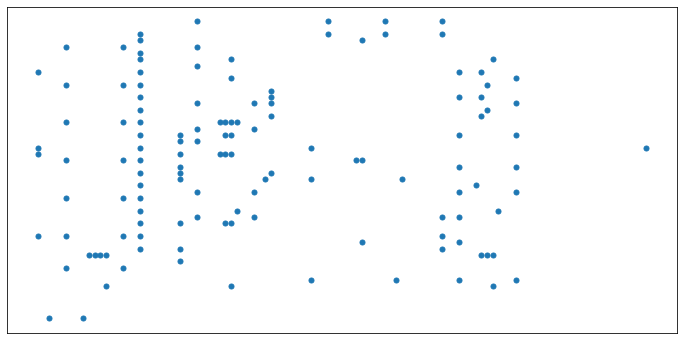

In [8]:
draw_graph(data.get_graph(), only_nodes=True)

## Solution state

In [9]:
class TspState(State):

    def __init__(self, nodes, edges):
        self.nodes = nodes
        self.edges = edges

    def objective(self):
        return sum(distances.euclidean(node[1], self.edges[node][1])
                   for node in self.nodes)
    
    def to_graph(self):
        
        graph = nx.Graph()

        for node, coord in self.nodes:
            graph.add_node(node, pos=coord)

        for node_from, node_to in self.edges.items():
            graph.add_edge(node_from[0], node_to[0])

        return graph

Destroy operators

In [10]:
degree_of_destruction = 0.25

def edges_to_remove(state):
    return int(len(state.edges) * degree_of_destruction)

In [25]:
def worst_removal(current, rnd_state):
    """
    Worst removal iteratively removes the 'worst' edges, that is,
    those edges that have the largest distance.
    """
    destroyed = copy.deepcopy(current)

    worst_edges = sorted(destroyed.nodes,
                         key=lambda node: distances.euclidean(node[1],
                                                              destroyed.edges[node][1]))

    for idx in range(edges_to_remove(current)):
        del destroyed.edges[worst_edges[-(idx + 1)]]

    return destroyed

In [26]:
def path_removal(current, rnd_state):
    """
    Removes an entire consecutive sub-path, that is, a series of
    contiguous edges.
    """
    destroyed = copy.deepcopy(current)
    
    node_idx = rnd_state.choice(len(destroyed.nodes))
    node = destroyed.nodes[node_idx]
    
    for _ in range(edges_to_remove(current)):
        node = destroyed.edges.pop(node)

    return destroyed

In [27]:
def random_removal(current, rnd_state):
    """
    Random removal iteratively removes random edges.
    """
    destroyed = copy.deepcopy(current)
    
    for idx in rnd_state.choice(len(destroyed.nodes),
                                edges_to_remove(current),
                                replace=False):
        del destroyed.edges[destroyed.nodes[idx]]

    return destroyed

Repair operators

In [28]:
def would_form_subcycle(from_node, to_node, state):
    for step in range(1, len(state.nodes)):
        if to_node not in state.edges:
            return False

        to_node = state.edges[to_node]
        
        if from_node == to_node and step != len(state.nodes) - 1:
            return True

    return False

In [15]:
def greedy_repair(current, rnd_state):
    visited = set(current.edges.values())
    shuffled_idcs = rnd_state.permutation(len(current.nodes))
    nodes = [current.nodes[idx] for idx in shuffled_idcs]

    while len(current.edges) != len(current.nodes):
        node = next(node for node in nodes 
                    if node not in current.edges)
        unvisited = {other for other in current.nodes
                     if other != node
                     if other not in visited
                     if not would_form_subcycle(node, other, current)}
        nearest = min(unvisited,
                      key=lambda other: distances.euclidean(node[1], other[1]))

        current.edges[node] = nearest
        visited.add(nearest)

    return current

## Initial solution

In [16]:
random_state = rnd.RandomState(SEED)
state = TspState(cities, {})

init_sol = greedy_repair(state, random_state)
print(f"Initial solution objective is {init_sol.objective()}.")

Initial solution objective is 913.


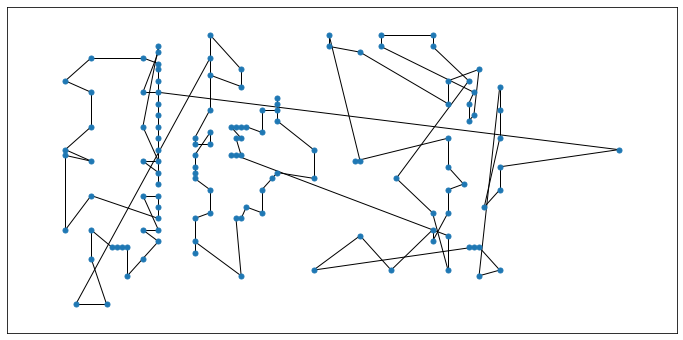

In [17]:
draw_graph(init_sol.to_graph())

Heuristic solution

Here we perform the ALNS procedure. The heuristic is given 60 seconds of runtime.

In [29]:
alns = ALNS(random_state)

alns.add_destroy_operator(random_removal)
alns.add_destroy_operator(path_removal)
alns.add_destroy_operator(worst_removal)

alns.add_repair_operator(greedy_repair)

In [19]:
criterion = HillClimbing()
weight_scheme = SimpleWeights([3, 2, 1, 0.5], 3, 1, 0.8)
stop = MaxRuntime(60)

result = alns.iterate(init_sol, weight_scheme, criterion, stop)

In [20]:
solution = result.best_state
objective = solution.objective()
pct_difference = 100 * (objective - optimal) / optimal

print(f"Best heuristic objective is {objective}.")
print(f"This is {pct_difference:.1f}% worse than the optimal solution, which is {optimal}.")

Best heuristic objective is 614.
This is 8.9% worse than the optimal solution, which is 564.


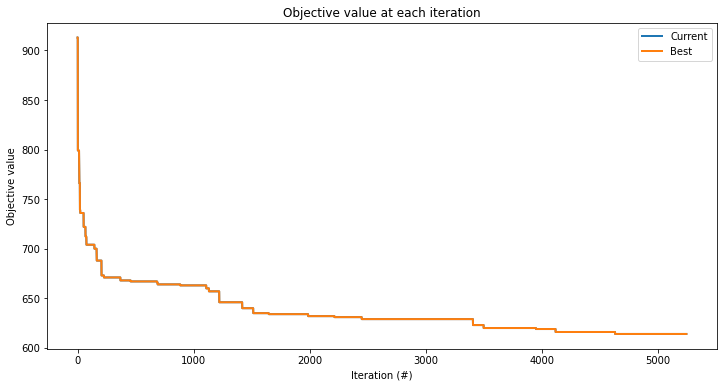

In [21]:
_, ax = plt.subplots(figsize=(12, 6))
result.plot_objectives(ax=ax, lw=2)

Let's have a look at the solution:

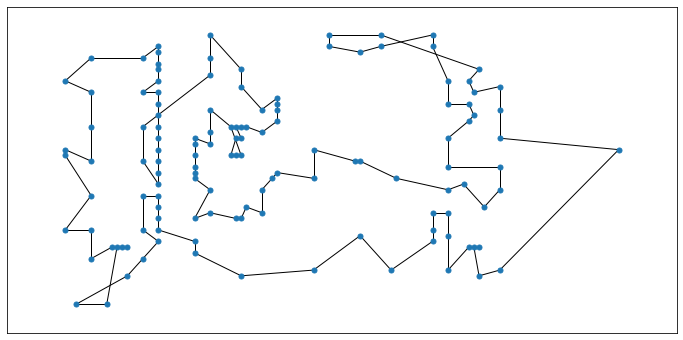

In [22]:
draw_graph(solution.to_graph())

## Post-processing



In [30]:
k = 7

In [31]:
def optimal_sub_path(nodes, start_node, end_node):


    def fix_bounds(permutation):
        return (start_node,) + permutation + (end_node,)

    def cost(sub_path):
        path = fix_bounds(sub_path)
        return sum(distances.euclidean(path[idx][1], path[idx + 1][1])
                   for idx in range(len(path) - 1))

    opt_path = min(itertools.permutations(nodes, k), key=cost)
    return fix_bounds(opt_path)

In [32]:
def post_process(state):
    state = copy.deepcopy(state)

    for start_node in state.nodes:
        nodes = []
        node = start_node
        for _ in range(k):
            node = state.edges[node]
            nodes.append(node)

        end_node = state.edges[node]
        opt_path = optimal_sub_path(nodes, start_node, end_node)
        for first, second in zip(opt_path, opt_path[1:]):
            state.edges[first] = second

    return state

In [33]:
new_solution = post_process(solution)
new_objective = new_solution.objective()
pct_difference = 100 * (new_objective - optimal) / optimal

print(f"New heuristic objective is {new_objective}.")
print(f"This is {pct_difference:.1f}% worse than the optimal solution, which is {optimal}.")

New heuristic objective is 600.
This is 6.4% worse than the optimal solution, which is 564.


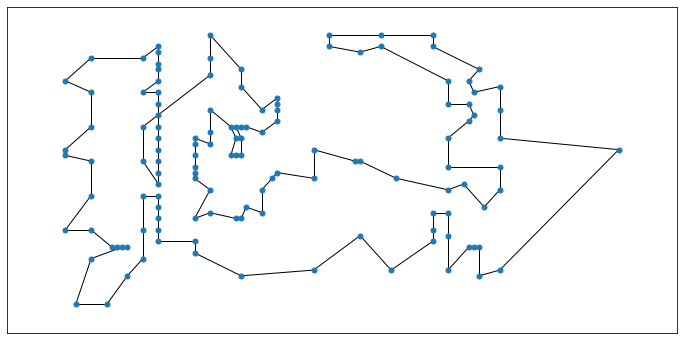

In [34]:
draw_graph(new_solution.to_graph())